### AdaBoost

En este notebook utilizaremos AdaBoostClassifier para entrenar y predecir sobre el dataset de entrenamiento, con dos preprocesamientos distintos:
* Uno muy similar al realizado en la parte 1 de este TP pero escalando los datos. 
* El segundo será el resultado de la función `preprocessing_significantes` con 90% de la varianza explicada.

Estos dos preprocesamientos los usaremos con un modelo de AdaBoost con `base_estimator` default (árboles). Luego, cambiaremos ese estimador por un MultinomialNB, y lo usaremos con los preprocesamientos de la parte 1 del TP y el equilibrado.

In [1]:
# Modelo 
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier

# Preprocessing
from preprocessing import preprocessing_base_parte_1, preprocessing_significantes, preprocessing_equilibrado

# Búsqueda
from sklearn.model_selection import train_test_split, GridSearchCV

# Metrics 
from sklearn.metrics import plot_roc_curve, roc_auc_score, classification_report, plot_confusion_matrix

# Plots
from matplotlib import pyplot as plt

#Otros
import pandas as pd
import numpy as np
import utils

In [2]:
df = utils.get_data()

## Modelo 1 - Árboles + Preprocessing primera parte

Será entrenado con las siguientes variables:

* **Ganancia/Pérdida declara en la bolsa argentina**: `ganancia_perdida_declarada_bolsa_argentina`
* **Edad**: `edad`
* **Rol familiar registrado**: `rol_familiar_registrado`
* **Años estudiados**: `anios_estudiados`

In [3]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
Y = df['tiene_alto_valor_adquisitivo']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, Y, random_state=112, stratify=Y)

X_train_1, X_test_1 = preprocessing_base_parte_1(X_train_1, X_test_1)

Usamos GridSearchCV con los siguientes hiperparámetros, y entrenamos los modelos

In [4]:
model = AdaBoostClassifier()
params = {'n_estimators':range(101, 502, 100),
          'learning_rate': np.logspace(-3, 0, 4),
          'algorithm': ('SAMME', 'SAMME.R')
         }

gscv1 = GridSearchCV(model, params, scoring='roc_auc', cv=25, n_jobs=-1, verbose=4)

In [5]:
gscv1.fit(X_train_1, y_train_1)

Fitting 25 folds for each of 40 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 14.4min finished


GridSearchCV(cv=25, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'algorithm': ('SAMME', 'SAMME.R'),
                         'learning_rate': array([0.001, 0.01 , 0.1  , 1.   ]),
                         'n_estimators': range(101, 502, 100)},
             scoring='roc_auc', verbose=4)

In [6]:
print("Los parámetros que mejor score obtuvieron para AdaBoost fueron:", gscv1.best_params_)
print("Con un Score (RocAUC) de: ", round(gscv1.best_score_, 4))

Los parámetros que mejor score obtuvieron para AdaBoost fueron: {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 501}
Con un Score (RocAUC) de:  0.9157


Dado que obtuvimos valores límites de la búsqueda la centralizaremos aún más:

Buscaremos con learnings rates mayores a 1, con el algoritmo SAMME.R y con más estimadores. Pero bajaremos el crossvalidation de 25 a 4.

In [7]:
model = AdaBoostClassifier(algorithm='SAMME.R')
params = {'n_estimators': list(range(501, 1502, 200)),
          'learning_rate': np.linspace(1, 2, 5)
         }
gscv1 = GridSearchCV(model, params, scoring='roc_auc', cv=4, n_jobs=-1, verbose=4)

In [8]:
gscv1.fit(X_train_1, y_train_1)

Fitting 4 folds for each of 30 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  4.7min finished


GridSearchCV(cv=4, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': array([1.  , 1.25, 1.5 , 1.75, 2.  ]),
                         'n_estimators': [501, 701, 901, 1101, 1301, 1501]},
             scoring='roc_auc', verbose=4)

In [9]:
print("Los parámetros que mejor score obtuvieron para AdaBoost fueron:", gscv1.best_params_)
print("Con un Score (RocAUC) de: ", round(gscv1.best_score_, 4))

Los parámetros que mejor score obtuvieron para AdaBoost fueron: {'learning_rate': 1.0, 'n_estimators': 1501}
Con un Score (RocAUC) de:  0.9168


El modelo promete muchísimo!

In [59]:
abc1 = gscv1.best_estimator_

In [60]:
abc1.fit(X_train_1, y_train_1)

AdaBoostClassifier(n_estimators=1501)

In [61]:
print(classification_report(y_test_1,abc1.predict(X_test_1), digits=4))

              precision    recall  f1-score   support

           0     0.8738    0.9521    0.9113      6181
           1     0.7895    0.5663    0.6595      1960

    accuracy                         0.8592      8141
   macro avg     0.8316    0.7592    0.7854      8141
weighted avg     0.8535    0.8592    0.8507      8141



Vemos que obtuvo buenas métricas en general. Relativamente buena precisión para los unos, pero con poco recall para ellos.

Muy buena recall para los ceros, pero con peor precisión.

El accuracy es alto (de los más altos obtenidos hasta ahora)

Veamos la matriz de confusión!

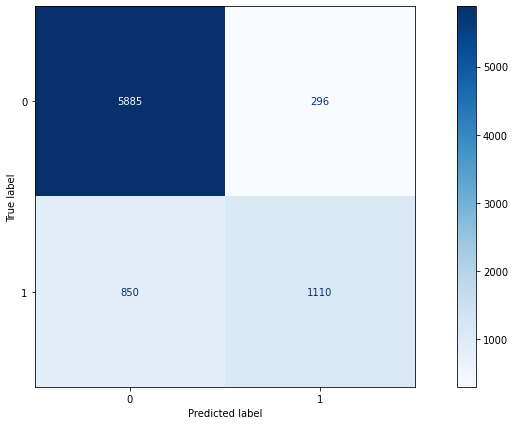

In [62]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(abc1, X_test_1, y_test_1, cmap=plt.cm.Blues, display_labels=['0', '1'], ax=ax)
plt.show()

Vemos en la matriz de confusión que hay muy pocos falsos positivos, pero en contraparte hay muchísimos falsos negativos. Esto coincide con los valores de recall y precision vistos en el reporte.

La matriz está bien, sin embargo la cantidad de FN es preocupante.


Veamos ahora la curva ROC y su puntuación AUC

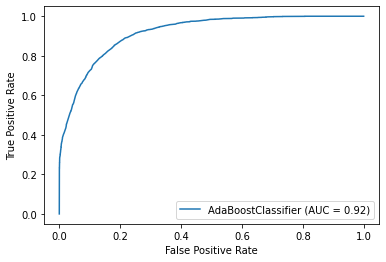

In [63]:
plot_roc_curve(abc1, X_test_1, y_test_1)

In [64]:
roc_auc_score(y_test_1, abc1.predict_proba(X_test_1)[:,1])

0.9181794769355729

Esta métrica se encuentra entre las más altas conseguidas hasta ahora!

## Modelo 2 - Árboles + Preprocessing significantes 90%

Se procederá a ejecutar un AdaBoost de árboles sobre un data frame que posee el 90% de la varianza explicada.

Esta vez, debido a la alta dimensionalidad, se utilizará gridsearch con poco crossvalidation (Kfold K=4) y en la búsqueda se usará una altura igual y en 200. Básicamente queremos buscar el mejor learning rate.

Veamos

In [16]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X)
Y = df['tiene_alto_valor_adquisitivo']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, Y, random_state=112, stratify=Y)

X_train_2, X_test_2 = preprocessing_significantes(X_train_2, X_test_2, variance=0.9)

/home/lukas/FIUBA/tp-datos-1c2021-de-angelis-riva-continanza/Parte2/preprocessing.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ganancia_perdida_declarada_bolsa_argentina'] = X_train['ganancia_perdida_declarada_bolsa_argentina'].apply(_log_scale)
/home/lukas/FIUBA/tp-datos-1c2021-de-angelis-riva-continanza/Parte2/preprocessing.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['ganancia_perdida_declarada_bolsa_argentina'] = X_test['ganancia_perdida_declarada_bolsa_argentina'].apply(

In [17]:
model = AdaBoostClassifier(n_estimators=200, algorithm='SAMME.R')
params = {'learning_rate': np.linspace(1, 2, 5)}

gscv2 = GridSearchCV(model, params, scoring='roc_auc', cv=4, n_jobs=-1, verbose=4)

In [18]:
gscv2.fit(X_train_2, y_train_2)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  1.9min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  2.6min remaining:   27.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.6min finished


GridSearchCV(cv=4, estimator=AdaBoostClassifier(n_estimators=200), n_jobs=-1,
             param_grid={'learning_rate': array([1.  , 1.25, 1.5 , 1.75, 2.  ])},
             scoring='roc_auc', verbose=4)

In [19]:
print("Los parámetros que mejor score obtuvieron para AdaBoost fueron:", gscv2.best_params_)
print("Con un Score (RocAUC) de: ", round(gscv2.best_score_, 4))

Los parámetros que mejor score obtuvieron para AdaBoost fueron: {'learning_rate': 1.0}
Con un Score (RocAUC) de:  0.8918


Se obtuvo un peor valor que en el preprocessing anterior, pero hay que tener en cuenta que no podíamos ser pretenciosos con la cantidad de estimadores, veamos qué sucede si ahora entrenamos un AdaBoost con el learning rate obtenido pero con una cantidad de estimadores más alta, en este caso probaremos con 1001.

Armemos entonces el modelo

In [20]:
abc2 = AdaBoostClassifier(algorithm='SAMME.R', learning_rate=1.00, n_estimators = 1001, random_state = 27)

In [21]:
abc2.fit(X_train_2, y_train_2)

AdaBoostClassifier(n_estimators=1001, random_state=27)

In [55]:
print(classification_report(y_test_2,abc2.predict(X_test_2), digits=4))

              precision    recall  f1-score   support

           0     0.8785    0.9115    0.8947      6181
           1     0.6834    0.6026    0.6405      1960

    accuracy                         0.8371      8141
   macro avg     0.7810    0.7570    0.7676      8141
weighted avg     0.8316    0.8371    0.8335      8141



Vemos que las métricas son mucho peores que las obtenidas en el anterior modelo.

Sin embargo este modelo obtuvo mayor recall para los unos, esto debería aparecer reflejado en la matriz de confusión:

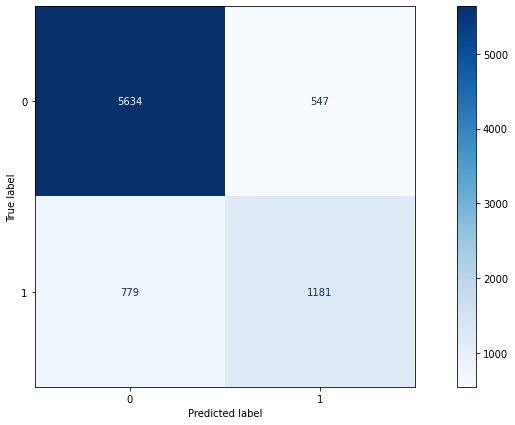

In [23]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(abc2, X_test_2, y_test_2, cmap=plt.cm.Blues, display_labels=['0', '1'], ax=ax)
plt.show()

Efectivamente vemos como los dos tipos de errores FP & FN están más equilibrados que en el modelo anterior.

Veamos ahora la curva Roc y su puntuación AUC

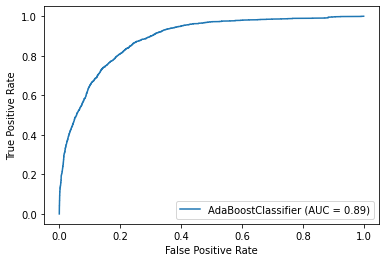

In [24]:
plot_roc_curve(abc2, X_test_2, y_test_2)

In [25]:
roc_auc_score(y_test_2, abc2.predict_proba(X_test_2)[:,1])

0.8874607090854462

Vemos que el valor obtenido es alto, pero regular. No es el mejor modelo.

## Modelo 3 -  Bayes + Preprocessing primera parte

En este caso cambiaremps el base_estimator (que por default es un árbol) a MultinomialNB, repitiendo el procedimiento anterior con dicho preprocessing, pero poniendo a todas las features entre 0 y 1, para ello utilizaremos el minmax scaler de sklearn

In [26]:
from sklearn.preprocessing import MinMaxScaler

In [27]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
Y = df['tiene_alto_valor_adquisitivo']

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, Y, random_state=112, stratify=Y)

X_train_3, X_test_3 = preprocessing_base_parte_1(X_train_3, X_test_3)
scaler = MinMaxScaler((0, 1))

X_train_3 = scaler.fit_transform(X_train_3)
X_test_3 = scaler.transform(X_test_3)

In [28]:
multinomialNB = MultinomialNB()
model = AdaBoostClassifier(base_estimator=multinomialNB, algorithm='SAMME.R', n_estimators=500)
params = {'base_estimator__alpha': np.linspace(0.25, 0.75, 3),
          'learning_rate': np.linspace(1, 1.75, 4)
         }
gscv3 = GridSearchCV(model, params, scoring='roc_auc', cv=5, n_jobs=-1, verbose=4)

In [29]:
gscv3.fit(X_train_3, y_train_3)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.4min finished


GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=MultinomialNB(),
                                          n_estimators=500),
             n_jobs=-1,
             param_grid={'base_estimator__alpha': array([0.25, 0.5 , 0.75]),
                         'learning_rate': array([1.  , 1.25, 1.5 , 1.75])},
             scoring='roc_auc', verbose=4)

In [30]:
print("Los parámetros que mejor score obtuvieron para AdaBoost fueron:", gscv3.best_params_)
print("Con un Score (RocAUC) de: ", round(gscv3.best_score_, 4))

Los parámetros que mejor score obtuvieron para AdaBoost fueron: {'base_estimator__alpha': 0.75, 'learning_rate': 1.5}
Con un Score (RocAUC) de:  0.8691


Este modelo no tiene mucha pinta, pero vamos a poner más estimadores.

In [31]:
nb = MultinomialNB(alpha = 0.75)
abc3 = AdaBoostClassifier(nb, algorithm='SAMME.R', learning_rate= 1.5, n_estimators = 1501, random_state = 27)

In [32]:
abc3.fit(X_train_3, y_train_3)

AdaBoostClassifier(base_estimator=MultinomialNB(alpha=0.75), learning_rate=1.5,
                   n_estimators=1501, random_state=27)

In [33]:
print(classification_report(y_test_3,abc3.predict(X_test_3)))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      6181
           1       0.68      0.49      0.57      1960

    accuracy                           0.82      8141
   macro avg       0.77      0.71      0.73      8141
weighted avg       0.81      0.82      0.81      8141



Vemos que evidentemente este modelo no es de los mejores hechos en el trabajo práctico. Se centra mucho en los ceros y bastante poco en los unos. Eso se va a poder reflejar en la matriz de confusión:

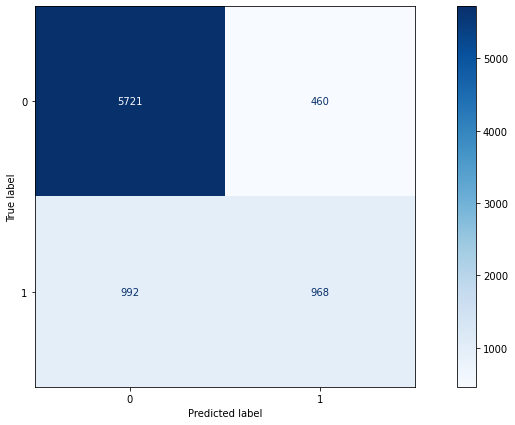

In [34]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(abc3, X_test_3, y_test_3, cmap=plt.cm.Blues, display_labels=['0', '1'], ax=ax)
plt.show()

Como ya fue comentado, este modelo predice muchos ceros, y esto se puede observar en la gran cantidad de falsos negativos obtenidos (los cuales son superiores a los verdaderos positivos). Aquí en la matriz de confusión vemos que este modelo no es tan bueno realmente.

Veamos de todas formas la curva ROC y su puntuación AUC

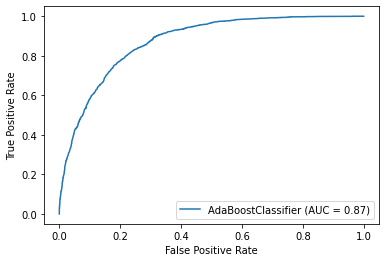

In [35]:
plot_roc_curve(abc3, X_test_3, y_test_3)

In [36]:
roc_auc_score(y_test_3, abc3.predict_proba(X_test_3)[:,1])

0.8716457032578441

La métrica AUC-ROC empeoró ligeramente. Y es de las peores obtenidas hasta el momento.

## Modelo 4 -  Bayes + Preprocessing equilibrado

En este caso cambiaremos el base_estimator (que por default es un árbol) a MultinomialNB.
Equilibraremos el data frame (es decir, habrá la misma cantidad de valores para cero como para uno).

Queremos ver cómo se comporta nuestro modelo basado en Naive Bayes frente a la situación de equilibrar el data frame de entrenamiento. Quizá así no se ve tan sesgado a predecir ceros debido a su alta tasa de aparición.


Pondremos a todas las features entre 0 y 1, para ello utilizaremos el minmax scaler de sklearn

In [37]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X)
Y = df['tiene_alto_valor_adquisitivo']

X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X, Y, random_state=112)
X_train_4, X_test_4, y_train_4, y_test_4 = preprocessing_equilibrado(X_train_4, X_test_4, y_train_4, y_test_4)

scaler = MinMaxScaler((0, 1))
X_train_4 = pd.DataFrame(scaler.fit_transform(X_train_4))
X_test_4 = pd.DataFrame(scaler.transform(X_test_4))

In [38]:
multinomialNB = MultinomialNB()
model = AdaBoostClassifier(base_estimator=multinomialNB, algorithm='SAMME.R', n_estimators=500)
params = {'base_estimator__alpha': np.linspace(0.25, 0.75, 3),
          'learning_rate': np.linspace(1, 1.75, 4)
         }
gscv4 = GridSearchCV(model, params, scoring='roc_auc', cv=5, n_jobs=-1, verbose=4)

In [39]:
gscv4.fit(X_train_4, y_train_4)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.1min finished


GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=MultinomialNB(),
                                          n_estimators=500),
             n_jobs=-1,
             param_grid={'base_estimator__alpha': array([0.25, 0.5 , 0.75]),
                         'learning_rate': array([1.  , 1.25, 1.5 , 1.75])},
             scoring='roc_auc', verbose=4)

In [40]:
print("Los parámetros que mejor score obtuvieron para AdaBoost fueron:", gscv4.best_params_)
print("Con un Score (RocAUC) de: ", round(gscv4.best_score_, 4))

Los parámetros que mejor score obtuvieron para AdaBoost fueron: {'base_estimator__alpha': 0.75, 'learning_rate': 1.0}
Con un Score (RocAUC) de:  0.8867


Nuevamente, este modelo no parece tener mucho futuro, pero es mejor que en anterior, por lo que vamos a realizar el modelo con más estimadores, en este caso 1501.

In [41]:
nb = MultinomialNB(alpha = 0.75)
abc4 = AdaBoostClassifier(nb, algorithm='SAMME.R', learning_rate=1.0, n_estimators = 1501, random_state = 27)

In [42]:
abc4.fit(X_train_4, y_train_4)

AdaBoostClassifier(base_estimator=MultinomialNB(alpha=0.75), n_estimators=1501,
                   random_state=27)

In [43]:
print(classification_report(y_test_4,abc4.predict(X_test_4)))

              precision    recall  f1-score   support

           0       0.99      0.35      0.52      6182
           1       0.33      0.99      0.49      1959

    accuracy                           0.51      8141
   macro avg       0.66      0.67      0.51      8141
weighted avg       0.83      0.51      0.51      8141



El modelo hizo cualquier cosa. Es el peor obtenido hasta el momento.

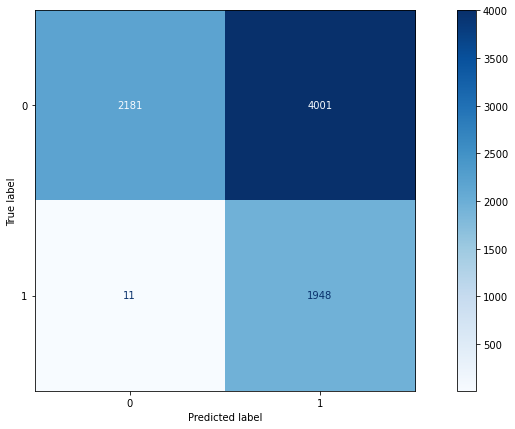

In [44]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(abc4, X_test_4, y_test_4, cmap=plt.cm.Blues, display_labels=['0', '1'], ax=ax)
plt.show()

Vemos que la matriz de confusión no tiene sentido alguno.

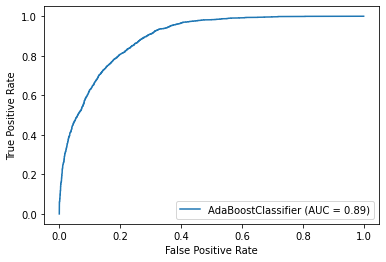

In [45]:
plot_roc_curve(abc4, X_test_4, y_test_4)

In [46]:
roc_auc_score(y_test_4, abc4.predict_proba(X_test_4)[:,1])

0.8921249411050112

Y vemos que el valor obtenido de RocAUC da alto, lo cual nos deja sorprendidos.

También podemos observar que la curva comienza a inclinarse bastante temprano en FalsePositiveRate.

### Persistencia de modelos

In [65]:
import pickle

In [66]:
pickle.dump(abc1, open("Modelos/AdaBoost/abc1.pickle", "wb"))
pickle.dump(abc2, open("Modelos/AdaBoost/abc2.pickle", "wb"))
pickle.dump(abc3, open("Modelos/AdaBoost/abc3.pickle", "wb"))
pickle.dump(abc4, open("Modelos/AdaBoost/abc4.pickle", "wb"))

# Predicción de HoldOut

Usaremos para predecir el AdaBoost obtenido para el preprocessing base.

In [67]:
abc1 = pickle.load(open("Modelos/AdaBoost/abc1.pickle", "rb"))

In [68]:
def holdout():
    ids, X = utils.get_holdout_data()
    X, _ = preprocessing_base_parte_1(X, X)
    return ids, X

In [69]:
ids, X = holdout()

In [70]:
utils.escribir_holdout(abc1.predict(X), "9 - AdaBoost", ids)